In [44]:
#### import pandas as pd
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from helper import *
from amftrack.notebooks.P_experiment.helper import get_polygons
%load_ext autoreload
%autoreload 2
plt.style.use('presentation.mplstyle')

%matplotlib widget

# Read the Excel file
path = r'C:\Users\coren\AMOLF-SHIMIZU Dropbox\Corentin Bisot\PC\Documents\PhD\Pexperiment'
path_excel = os.path.join(path,'summary.xlsx')
df = pd.read_excel(path_excel)
df['date_from_unique_id'] = pd.to_datetime(df['unique_id'].str.split('_').str[1], format='%Y%m%d')
    
# Convert 'day' column to datetime
df['day_sample'] = pd.to_datetime(df['day_sample'], format='%Y%m%d')  # Update the format as necessary
df['day_start'] = pd.to_datetime(df['start'], format='%Y%m%d')  # Update the format as necessary

df['time_elapsed'] = df['day_sample'] - df['day_start']
df['time_elapsed_day'] = df['time_elapsed'].dt.days
df['time_since_crossing'] = df['day_sample'] - df['date_from_unique_id']
df['t2 (day)'] = df['time_since_crossing'].dt.days
df['t1 (day)'] = df['time_elapsed_day']-df['t2 (day)']
df['treatment'] = df['treatment'].fillna('none')
df['wet_weight_measured'] = df['wet weight']

df['wet weight'] = df['wet weight']-df['lost weight']

grouped = df.groupby(['plate', 'type','day_sample', "time_elapsed_day", "t1 (day)", "treatment", 't2 (day)', "arrangement","day_start"]).agg({
    'totP (ug)': 'sum',
    'wet weight': ['sum', 'median'],
    "wet_weight_measured":"sum",
    'dry weight': 'sum'
}).reset_index()

# Rename columns
grouped.columns = ['_'.join(col).strip() if col[0] == 'wet weight' else col[0] for col in grouped.columns]
grouped = grouped.rename(columns={
    'wet weight_sum': 'tot_wet_weight',
    'wet weight_median': 'wet_weight_median'
})
grouped['C_P'] = grouped['totP (ug)'] / grouped['tot_wet_weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6


df['C_P'] = df['totP (ug)'] / df['wet weight']
df['P_content'] = df['totP (ug)'] / df['dry weight']/1e6
tot_weights = grouped[grouped['type'].isin(["agartot", "rootagartot"])].set_index(['plate', 'type'])['wet_weight_measured'].to_dict()

# Function to determine the 'measured_tot_wet_weight' based on conditions
def get_tot_weight(row):
    if row['type'] == 'agar' and (row['plate'], 'agartot') in tot_weights:
        return tot_weights[(row['plate'], 'agartot')]
    elif row['type'] == 'rootagar' and (row['plate'], 'rootagartot') in tot_weights:
        return tot_weights[(row['plate'], 'rootagartot')]
    else:
        return row['wet_weight_measured']

# Apply the function to get 'measured_tot_wet_weight' column
grouped['measured_tot_wet_weight'] = grouped.apply(get_tot_weight, axis=1)
grouped= grouped[grouped['type'] != 'rootagartot']
grouped= grouped[grouped['type'] != 'agartot']

# Step 2: Compute the average "wet weight" for type 'agar' and 'rootagar'
average_wet_weight_agar = grouped[grouped['type'] == 'agar']['measured_tot_wet_weight'].mean()
average_wet_weight_rootagar = grouped[grouped['type'] == 'rootagar']['measured_tot_wet_weight'].mean()

# Step 3: Replace rows in the 'average weight' column accordingly
grouped['average weight'] = None  # Initialize column with None values
grouped.loc[grouped['type'] == 'agar', 'average weight'] = average_wet_weight_agar
grouped.loc[grouped['type'] == 'rootagar', 'average weight'] = average_wet_weight_rootagar
grouped.loc[grouped['type'] == 'agar', 'fullP'] = grouped.loc[grouped['type'] == 'agar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'agar', 'C_P']
grouped.loc[grouped['type'] == 'rootagar', 'fullP'] = grouped.loc[grouped['type'] == 'rootagar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'rootagar', 'C_P']
grouped.loc[grouped['type'] == 'root', 'fullP'] = grouped.loc[grouped['type'] == 'root', 'totP (ug)']
grouped.loc[grouped['type'] == 'agar', 'fullP_volume_adapt'] = average_wet_weight_agar *grouped.loc[grouped['type'] == 'agar', 'C_P']
grouped.loc[grouped['type'] == 'rootagar', 'fullP_volume_adapt'] = average_wet_weight_rootagar *grouped.loc[grouped['type'] == 'rootagar', 'C_P']
grouped.loc[grouped['type'] == 'root', 'fullP_volume_adapt'] = grouped.loc[grouped['type'] == 'root', 'totP (ug)']
totP_theory = 100
grouped['scaling_factor'] = totP_theory/grouped.groupby('plate')['fullP'].transform('sum')

# Multiply 'fullP' by the scaling factor to get 'fullP_rescaled'
grouped['fullP_rescaled'] = grouped['fullP'] * grouped['scaling_factor']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
average_wet_weight_agar,average_wet_weight_rootagar

(25.633199999999995, 21.947889285714286)

In [42]:
tot_weights

{(447.0, 'agartot'): 26.19,
 (447.0, 'rootagartot'): 20.0163,
 (468.0, 'agartot'): 25.555,
 (468.0, 'rootagartot'): 21.65,
 (471.0, 'agartot'): 25.3,
 (471.0, 'rootagartot'): 21.0,
 (478.0, 'agartot'): 25.0,
 (478.0, 'rootagartot'): 21.4,
 (487.0, 'rootagartot'): 21.56,
 (492.0, 'agartot'): 26.11,
 (492.0, 'rootagartot'): 22.646}

In [39]:
average_wet_weight_agar,average_wet_weight_rootagar

(26.467, 23.7877)

In [8]:
grouped.columns

Index(['plate', 'type', 'day_sample', 'time_elapsed_day', 't1 (day)',
       'treatment', 't2 (day)', 'arrangement', 'day_start', 'totP (ug)',
       'tot_wet_weight', 'wet_weight_median', 'wet_weight_measured',
       'dry weight', 'C_P', 'P_content', 'measured_tot_wet_weight',
       'average weight', 'fullP', 'scaling_factor', 'fullP_rescaled'],
      dtype='object')

C:\Users\coren\AppData\Local\Temp\ipykernel_22284\2662143038.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x = select.groupby('plate')['arrangement'].agg(lambda x: mode(x)[0][0]).values
C:\Users\coren\AppData\Local\Temp\ipykernel_22284\2662143038.py:10: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  x = select.groupby('plate')['arrangement'].agg(lambda x: mode(x)[0][0]).values


<AxesSubplot: xlabel='Category', ylabel='Value'>

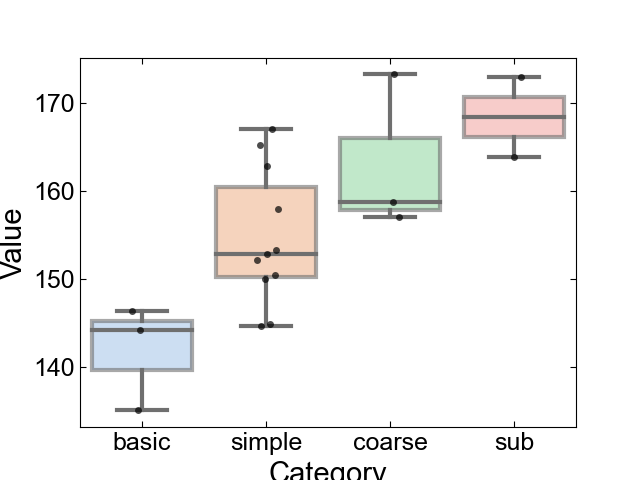

In [3]:
from scipy.stats import mode
fig, ax = plt.subplots()

select= grouped[grouped['treatment']=='100P']
select= select[select['type'] != 'rootagartot']
select= select[select['type'] != 'agartot']
select = select[select['plate']!=431]
select = select[select['plate']!=487]
y = select.groupby('plate')['fullP'].sum().values
x = select.groupby('plate')['arrangement'].agg(lambda x: mode(x)[0][0]).values
df_arrange = pd.DataFrame({'Category': x, 'Value': y})

# Create the boxplot
sns.boxplot(x='Category', y='Value', data=df_arrange, palette='pastel', boxprops=dict(alpha=.6))

# Add individual scatter points
sns.stripplot(x='Category', y='Value', data=df_arrange, jitter=True, marker='o', alpha=0.7, color='black')


C:\Users\coren\AppData\Local\Temp\ipykernel_22284\2730542886.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x = select.groupby('plate')['arrangement'].agg(lambda x: mode(x)[0][0]).values
C:\Users\coren\AppData\Local\Temp\ipykernel_22284\2730542886.py:10: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  x = select.groupby('plate')['arrangement'].agg(lambda x: mode(x)[0][0]).values


<AxesSubplot: xlabel='Category', ylabel='Value'>

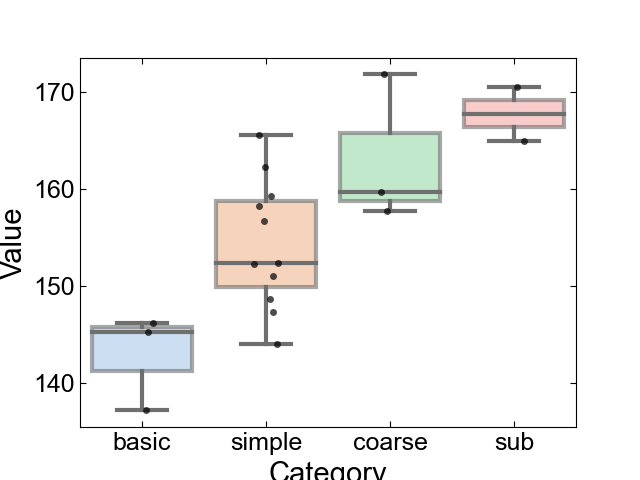

In [56]:
from scipy.stats import mode
fig, ax = plt.subplots()

select= grouped[grouped['treatment']=='100P']
select= select[select['type'] != 'rootagartot']
select= select[select['type'] != 'agartot']
select = select[select['plate']!=431]
select = select[select['plate']!=487]
y = select.groupby('plate')['fullP_volume_adapt'].sum().values
x = select.groupby('plate')['arrangement'].agg(lambda x: mode(x)[0][0]).values
df_arrange = pd.DataFrame({'Category': x, 'Value': y})

# Create the boxplot
sns.boxplot(x='Category', y='Value', data=df_arrange, palette='pastel', boxprops=dict(alpha=.6))

# Add individual scatter points
sns.stripplot(x='Category', y='Value', data=df_arrange, jitter=True, marker='o', alpha=0.7, color='black')


C:\Users\coren\AppData\Local\Temp\ipykernel_22284\1148152207.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x = select.groupby('plate')['day_sample'].agg(lambda x: np.datetime_as_string(mode(x)[0][0],unit='D')).values
C:\Users\coren\AppData\Local\Temp\ipykernel_22284\1148152207.py:10: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  x = select.groupby('plate')['day_sample'].agg(lambda x: np.datetime_as_string(mode(x)[0][0],unit

<AxesSubplot: xlabel='Category', ylabel='Value'>

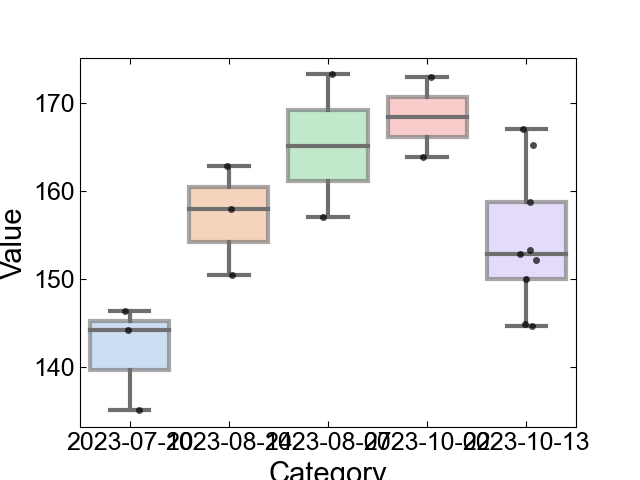

In [51]:
from scipy.stats import mode
fig, ax = plt.subplots()

select= grouped[grouped['treatment']=='100P']
select= select[select['type'] != 'rootagartot']
select= select[select['type'] != 'agartot']
select = select[select['plate']!=431]
select = select[select['plate']!=487]
y = select.groupby('plate')['fullP'].sum().values
x = select.groupby('plate')['day_sample'].agg(lambda x: np.datetime_as_string(mode(x)[0][0],unit='D')).values
df_arrange = pd.DataFrame({'Category': x, 'Value': y})

# Create the boxplot
sns.boxplot(x='Category', y='Value', data=df_arrange, palette='pastel', boxprops=dict(alpha=.6))

# Add individual scatter points
sns.stripplot(x='Category', y='Value', data=df_arrange, jitter=True, marker='o', alpha=0.7, color='black')


C:\Users\coren\AppData\Local\Temp\ipykernel_22284\3844597944.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x = select.groupby('plate')['day_sample'].agg(lambda x: np.datetime_as_string(mode(x)[0][0],unit='D')).values
C:\Users\coren\AppData\Local\Temp\ipykernel_22284\3844597944.py:10: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  x = select.groupby('plate')['day_sample'].agg(lambda x: np.datetime_as_string(mode(x)[0][0],unit

<AxesSubplot: xlabel='Category', ylabel='Value'>

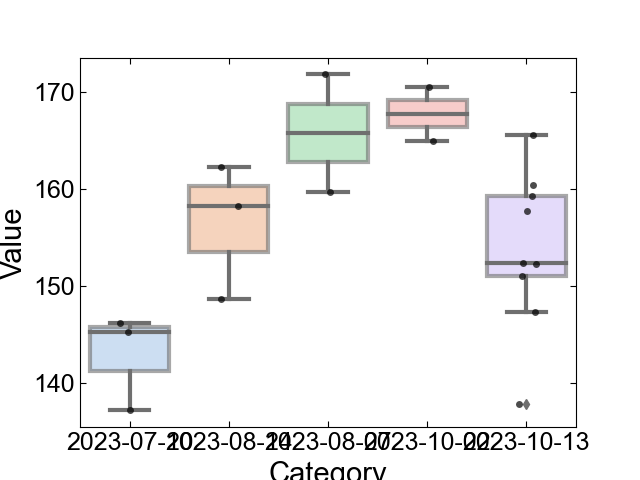

In [71]:
from scipy.stats import mode
fig, ax = plt.subplots()

select= grouped[grouped['treatment']=='100P']
select= select[select['type'] != 'rootagartot']
select= select[select['type'] != 'agartot']
select = select[select['plate']!=431]
select = select[select['plate']!=487]
y = select.groupby('plate')['fullP_volume_adapt'].sum().values
x = select.groupby('plate')['day_sample'].agg(lambda x: np.datetime_as_string(mode(x)[0][0],unit='D')).values
df_arrange = pd.DataFrame({'Category': x, 'Value': y})

# Create the boxplot
sns.boxplot(x='Category', y='Value', data=df_arrange, palette='pastel', boxprops=dict(alpha=.6))

# Add individual scatter points
sns.stripplot(x='Category', y='Value', data=df_arrange, jitter=True, marker='o', alpha=0.7, color='black')


(array([1., 1., 3., 2., 2., 2., 3., 1., 2., 2.]),
 array([137.14862085, 140.61618177, 144.08374269, 147.5513036 ,
        151.01886452, 154.48642543, 157.95398635, 161.42154727,
        164.88910818, 168.3566691 , 171.82423002]),
 <BarContainer object of 10 artists>)

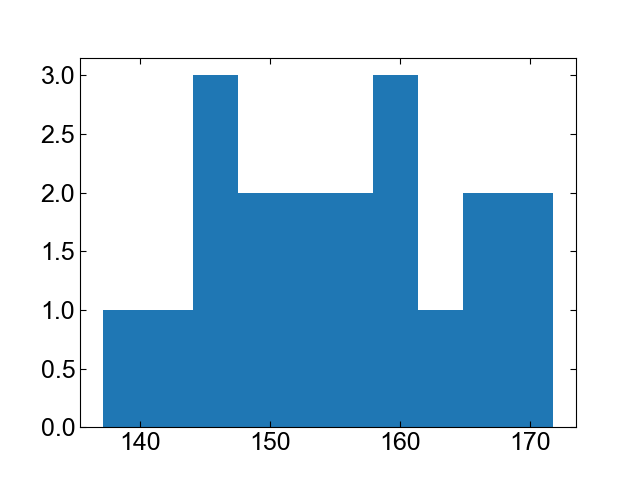

In [55]:
fig, ax = plt.subplots()

ax.hist(select.groupby('plate')['fullP_volume_adapt'].sum())

C:\Users\coren\AppData\Local\Temp\ipykernel_22284\2225118132.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


<AxesSubplot: >

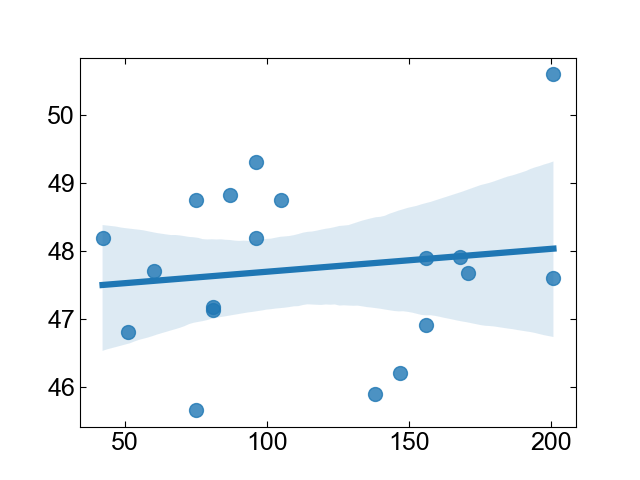

In [125]:
fig, ax = plt.subplots()

select= grouped[grouped['treatment']=='100P']
select= select[select['type'] != 'rootagartot']
select= select[select['type'] != 'agartot']
select = select[select['plate']!=431]
select = select[select['plate']!=487]
y = select.groupby('plate')['measured_tot_wet_weight'].sum().values
x = select.groupby('plate')['t1 (day)'].sum().values
sns.regplot(x=x,y=y)

<AxesSubplot: xlabel='totP (ug)', ylabel='fullP'>

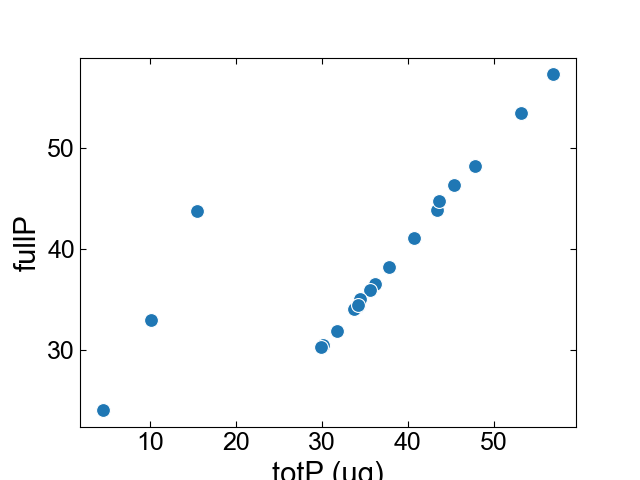

In [121]:
fig,ax = plt.subplots()

roots = grouped[grouped['type']=='rootagar']
roots = roots[roots['treatment']=='100P']

roots = roots[roots['plate']!=431]
sns.scatterplot(roots,x= 'totP (ug)',y = 'fullP')
# sns.regplot(roots,x= 't1 (day)',y = 'C_P')

# for index,row in roots.iterrows():
#     ax.text(row['t1 (day)'],row['C_P'],row['plate'])

In [130]:
select= select[select['type'] != 'rootagartot']
select= select[select['type'] != 'agartot']
select = select[select['plate']!=431]
select = select[select['plate']!=487]
select.groupby('plate')['fullP_volume_adapt'].sum()

plate
416.0    146.188922
420.0    137.148621
427.0    145.282692
436.0    162.311892
439.0    171.824230
440.0    158.289807
443.0    159.706457
447.0    164.944930
460.0    148.663201
481.0    152.295913
482.0    156.665785
483.0    151.014143
485.0    147.348129
486.0    157.753862
490.0    152.397977
491.0    159.302845
492.0    170.565526
494.0    143.985728
495.0    165.555859
Name: fullP_volume_adapt, dtype: float64

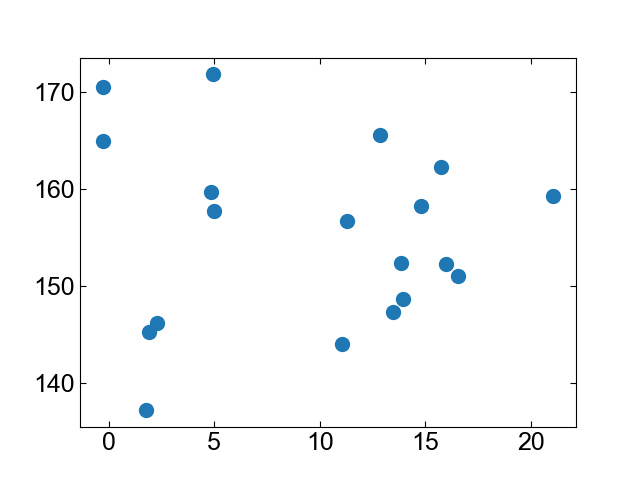

In [3]:
select= grouped[grouped['treatment']=='100P']

select= select[select['type'] != 'rootagartot']
select= select[select['type'] != 'agartot']
select = select[select['plate']!=431]
select = select[select['plate']!=487]
# select= select[select['type'] =='agar']
series1 = select.groupby('plate')['fullP_volume_adapt'].sum()
select_df = df
# select_df = select_df[select_df['type']=='agar']
series2 = select_df.groupby('plate')['totP (ug)'].min()

# Create DataFrames from the Series
df1 = pd.DataFrame({'plate': series1.index, 'fullP_volume_adapt_sum': series1.values})
df2 = pd.DataFrame({'plate': series2.index, 'totP (ug)_mean': series2.values})

# Merge the DataFrames on the 'plate' column
result_df = pd.merge(df1, df2, on='plate')
fig,ax = plt.subplots()
ax.scatter(result_df['totP (ug)_mean'],result_df['fullP_volume_adapt_sum'])

In [33]:
C_max

2.746020351691049

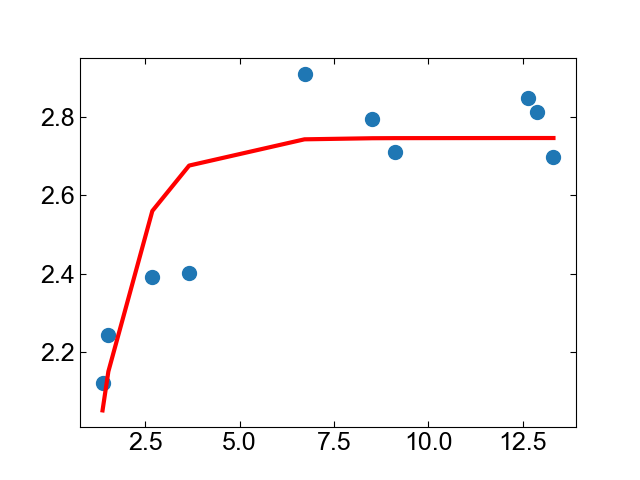

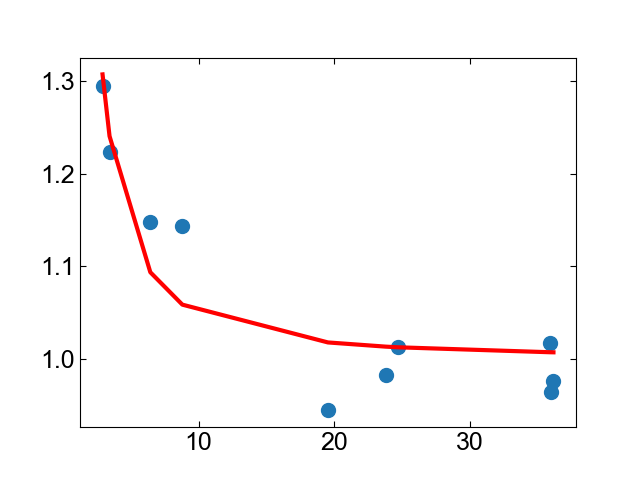

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def fit_function(wet_weight, C_max):
    return C_max * (1 - np.exp(-wet_weight))
select = df[df['type'] == 'agar0P']
x_data = select['wet weight']
y_data = select['C_P']

# Perform curve fitting
params, covariance = curve_fit(fit_function, x_data, y_data)

# Extract the fitted parameter C_max
C_max = params[0]
x_data = np.array(sorted(x_data.values))
# Generate fitted values for the curve
y_fit = fit_function(x_data, C_max)

select= df[df['type'] == 'agar0P']
fig,ax = plt.subplots()

ax.scatter(select['wet weight'],select['C_P'])
ax.plot(x_data, y_fit, 'r-', label=f'Fit (C_max={C_max:.2f})')
fig,ax = plt.subplots()

select = df[df['type'] == 'agar0P']
x_data = select['totP (ug)']
y_data = C_max/select['C_P']
ax.scatter(x_data,y_data)
def fit_function(x, C_max):
    return 1+C_max * 1/x**(3/2)
params, covariance = curve_fit(fit_function, x_data, y_data)

# Extract the fitted parameter C_max
C_max2 = params[0]
x_data = np.array(sorted(x_data.values))
# Generate fitted values for the curve
y_fit = fit_function(x_data, C_max2)
ax.plot(x_data, y_fit, 'r-', label=f'Fit (C_max={C_max:.2f})')


In [34]:
C_max2

1.5299409601188767

In [40]:
# Read the Excel file
path = r'C:\Users\coren\AMOLF-SHIMIZU Dropbox\Corentin Bisot\PC\Documents\PhD\Pexperiment'
path_excel = os.path.join(path, 'summary.xlsx')
df2 = pd.read_excel(path_excel)
df2['date_from_unique_id'] = pd.to_datetime(df2['unique_id'].str.split('_').str[1], format='%Y%m%d')

# Convert 'day' column to datetime
df2['day_sample'] = pd.to_datetime(df2['day_sample'], format='%Y%m%d')  # Update the format as necessary
df2['day_start'] = pd.to_datetime(df2['start'], format='%Y%m%d')  # Update the format as necessary

df2['time_elapsed'] = df2['day_sample'] - df2['day_start']
df2['time_elapsed_day'] = df2['time_elapsed'].dt.days
df2['time_since_crossing'] = df2['day_sample'] - df2['date_from_unique_id']
df2['t2 (day)'] = df2['time_since_crossing'].dt.days
df2['t1 (day)'] = df2['time_elapsed_day'] - df2['t2 (day)']
df2['treatment'] = df2['treatment'].fillna('none')
df2['wet_weight_measured'] = df2['wet weight']

df2['wet weight'] = df2['wet weight'] - df2['lost weight']
df2['totP (ug)'] = df2['totP (ug)'] * fit_function(df2['totP (ug)'], C_max2)

grouped2 = df2.groupby(
    ['plate', 'type', 'day_sample',"start", "time_elapsed_day", "t1 (day)", "treatment", 't2 (day)', "arrangement",
     "day_start"]).agg({
    'totP (ug)': 'sum',
    'wet weight': ['sum', 'median'],
    "wet_weight_measured": "sum",
    'dry weight': 'sum'
}).reset_index()

# Rename columns
grouped2.columns = ['_'.join(col).strip() if col[0] == 'wet weight' else col[0] for col in grouped2.columns]
grouped2 = grouped2.rename(columns={
    'wet weight_sum': 'tot_wet_weight',
    'wet weight_median': 'wet_weight_median'
})
grouped2['C_P'] = grouped2['totP (ug)'] / grouped2['tot_wet_weight']
grouped2['P_content'] = grouped2['totP (ug)'] / grouped2['dry weight'] / 1e6

df2['C_P'] = df2['totP (ug)'] / df2['wet weight']
df2['P_content'] = df2['totP (ug)'] / df2['dry weight'] / 1e6
tot_weights = grouped2[grouped2['type'].isin(["agartot", "rootagartot"])].set_index(['plate', 'type'])[
    'wet_weight_measured'].to_dict()


# Function to determine the 'measured_tot_wet_weight' based on conditions
def get_tot_weight(row):
    if row['type'] == 'agar' and (row['plate'], 'agartot') in tot_weights:
        return tot_weights[(row['plate'], 'agartot')]
    elif row['type'] == 'rootagar' and (row['plate'], 'rootagartot') in tot_weights:
        return tot_weights[(row['plate'], 'rootagartot')]
    else:
        return row['wet_weight_measured']


# Apply the function to get 'measured_tot_wet_weight' column
grouped2['measured_tot_wet_weight'] = grouped2.apply(get_tot_weight, axis=1)
grouped2 = grouped2[grouped2['type'] != 'rootagartot']
grouped2 = grouped2[grouped2['type'] != 'agartot']

# Step 2: Compute the average "wet weight" for type 'agar' and 'rootagar'
average_wet_weight_agar = grouped2[grouped2['type'] == 'agar']['measured_tot_wet_weight'].mean()
average_wet_weight_rootagar = grouped2[grouped2['type'] == 'rootagar']['measured_tot_wet_weight'].mean()

# Step 3: Replace rows in the 'average weight' column accordingly
grouped2['average weight'] = None  # Initialize column with None values
grouped2.loc[grouped2['type'] == 'agar', 'average weight'] = average_wet_weight_agar
grouped2.loc[grouped2['type'] == 'rootagar', 'average weight'] = average_wet_weight_rootagar
grouped2.loc[grouped2['type'] == 'agar', 'fullP'] = grouped2.loc[grouped2['type'] == 'agar', 'measured_tot_wet_weight'] * \
                                                    grouped2.loc[grouped2['type'] == 'agar', 'C_P']
grouped2.loc[grouped2['type'] == 'rootagar', 'fullP'] = grouped2.loc[
                                                            grouped2['type'] == 'rootagar', 'measured_tot_wet_weight'] * \
                                                        grouped2.loc[grouped2['type'] == 'rootagar', 'C_P']
grouped2.loc[grouped2['type'] == 'root', 'fullP'] = grouped2.loc[grouped2['type'] == 'root', 'totP (ug)']
grouped2.loc[grouped2['type'] == 'agar', 'fullP_volume_adapt'] = average_wet_weight_agar * grouped2.loc[
    grouped2['type'] == 'agar', 'C_P']
grouped2.loc[grouped2['type'] == 'rootagar', 'fullP_volume_adapt'] = average_wet_weight_rootagar * grouped2.loc[
    grouped2['type'] == 'rootagar', 'C_P']
grouped2.loc[grouped2['type'] == 'root', 'fullP_volume_adapt'] = grouped2.loc[grouped2['type'] == 'root', 'totP (ug)']
totP_theory = 100
grouped2['scaling_factor'] = totP_theory / grouped2.groupby('plate')['fullP'].transform('sum')

# Multiply 'fullP' by the scaling factor to get 'fullP_rescaled'
grouped2['fullP_rescaled'] = grouped2['fullP'] * grouped2['scaling_factor']

C:\Users\coren\AppData\Local\Temp\ipykernel_1028\1662857012.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x = select.groupby('plate')['arrangement'].agg(lambda x: mode(x)[0][0]).values
C:\Users\coren\AppData\Local\Temp\ipykernel_1028\1662857012.py:10: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  x = select.groupby('plate')['arrangement'].agg(lambda x: mode(x)[0][0]).values


<AxesSubplot: xlabel='Category', ylabel='Value'>

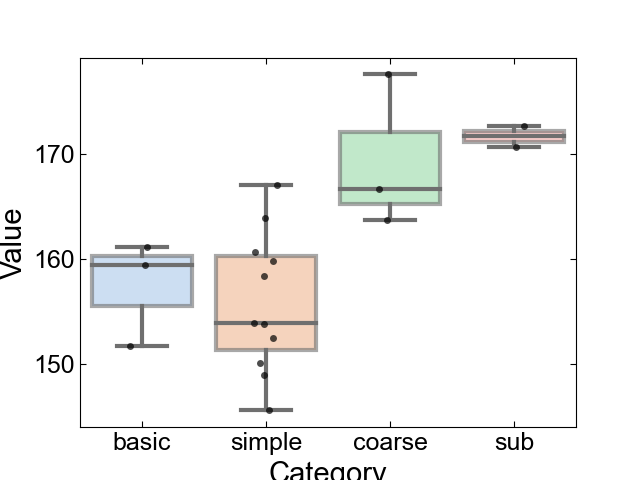

In [26]:
from scipy.stats import mode
fig, ax = plt.subplots()

select= grouped2[grouped2['treatment']=='100P']
select= select[select['type'] != 'rootagartot']
select= select[select['type'] != 'agartot']
select = select[select['plate']!=431]
select = select[select['plate']!=487]
y = select.groupby('plate')['fullP_volume_adapt'].sum().values
x = select.groupby('plate')['arrangement'].agg(lambda x: mode(x)[0][0]).values
df_arrange = pd.DataFrame({'Category': x, 'Value': y})

# Create the boxplot
sns.boxplot(x='Category', y='Value', data=df_arrange, palette='pastel', boxprops=dict(alpha=.6))

# Add individual scatter points
sns.stripplot(x='Category', y='Value', data=df_arrange, jitter=True, marker='o', alpha=0.7, color='black')


C:\Users\coren\AppData\Local\Temp\ipykernel_1028\806211300.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x = select.groupby('plate')['arrangement'].agg(lambda x: mode(x)[0][0]).values
C:\Users\coren\AppData\Local\Temp\ipykernel_1028\806211300.py:10: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  x = select.groupby('plate')['arrangement'].agg(lambda x: mode(x)[0][0]).values


<AxesSubplot: xlabel='Category', ylabel='Value'>

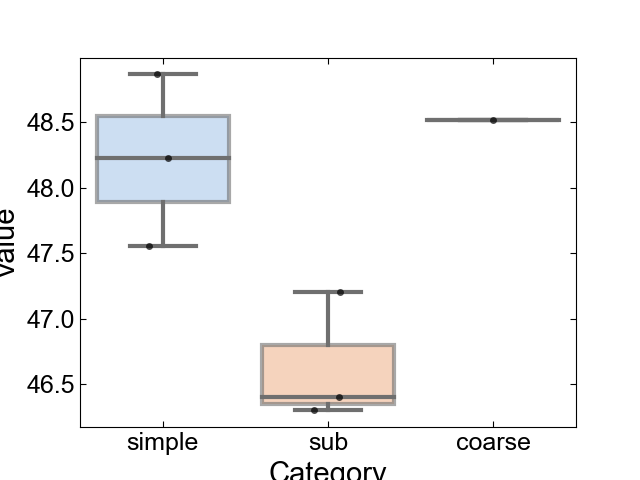

In [24]:
from scipy.stats import mode
fig, ax = plt.subplots()

select= grouped2[grouped2['treatment']=='0P']
select= select[select['type'] != 'rootagartot']
select= select[select['type'] != 'agartot']
select = select[select['plate']!=431]
select = select[select['plate']!=487]
y = select.groupby('plate')['measured_tot_wet_weight'].sum().values
x = select.groupby('plate')['arrangement'].agg(lambda x: mode(x)[0][0]).values
df_arrange = pd.DataFrame({'Category': x, 'Value': y})

# Create the boxplot
sns.boxplot(x='Category', y='Value', data=df_arrange, palette='pastel', boxprops=dict(alpha=.6))

# Add individual scatter points
sns.stripplot(x='Category', y='Value', data=df_arrange, jitter=True, marker='o', alpha=0.7, color='black')


C:\Users\coren\AppData\Local\Temp\ipykernel_1028\37199810.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
C:\Users\coren\AppData\Local\Temp\ipykernel_1028\37199810.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x = select.groupby('plate')['day_sample'].agg(lambda x: np.datetime_as_string(mode(x)[0][0],unit='D')).values
C:\User

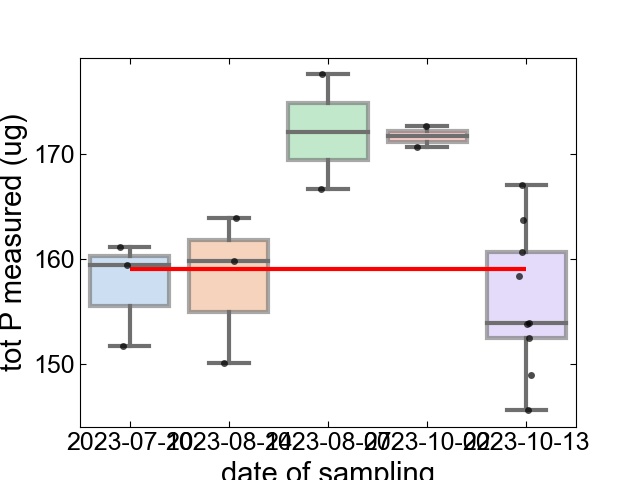

In [41]:
from scipy.stats import mode
fig, ax = plt.subplots()

select= grouped2[grouped2['treatment']=='100P']
select= select[select['type'] != 'rootagartot']
select= select[select['type'] != 'agartot']
select = select[select['plate']!=431]
select = select[select['plate']!=487]
y = select.groupby('plate')['fullP_volume_adapt'].sum().values
x = select.groupby('plate')['day_sample'].agg(lambda x: np.datetime_as_string(mode(x)[0][0],unit='D')).values
df_arrange = pd.DataFrame({'Category': x, 'Value': y})

# Create the boxplot
sns.boxplot(x='Category', y='Value', data=df_arrange, palette='pastel', boxprops=dict(alpha=.6))

# Add individual scatter points
sns.stripplot(x='Category', y='Value', data=df_arrange, jitter=True, marker='o', alpha=0.7, color='black')
ax.set_xlabel('date of sampling')
ax.set_ylabel('tot P measured (ug)')
ax.hlines(159,xmin = np.min(x),xmax = np.max(x),color = "red")

C:\Users\coren\AppData\Local\Temp\ipykernel_1028\1991564688.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x = select.groupby('plate')['start'].agg(lambda x: np.datetime_as_string(mode(x)[0][0],unit='D')).values
C:\Users\coren\AppData\Local\Temp\ipykernel_1028\1991564688.py:10: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  x = select.groupby('plate')['start'].agg(lambda x: np.datetime_as_string(mode(x)[0][0],unit='D')).value

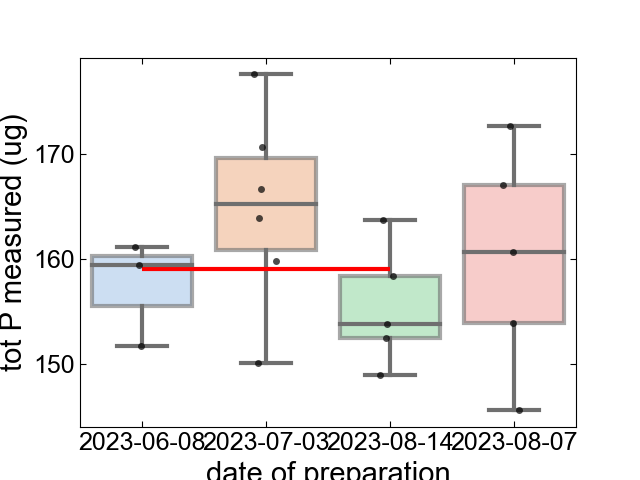

In [43]:
from scipy.stats import mode
fig, ax = plt.subplots()

select= grouped2[grouped2['treatment']=='100P']
select= select[select['type'] != 'rootagartot']
select= select[select['type'] != 'agartot']
select = select[select['plate']!=431]
select = select[select['plate']!=487]
y = select.groupby('plate')['fullP_volume_adapt'].sum().values
x = select.groupby('plate')['start'].agg(lambda x: np.datetime_as_string(mode(x)[0][0],unit='D')).values
df_arrange = pd.DataFrame({'Category': x, 'Value': y})

# Create the boxplot
sns.boxplot(x='Category', y='Value', data=df_arrange, palette='pastel', boxprops=dict(alpha=.6))

# Add individual scatter points
sns.stripplot(x='Category', y='Value', data=df_arrange, jitter=True, marker='o', alpha=0.7, color='black')
ax.set_xlabel('date of preparation')
ax.set_ylabel('tot P measured (ug)')
ax.hlines(159,xmin = np.min(x),xmax = np.max(x),color = "red")

In [32]:
y = select.groupby('plate')['fullP_volume_adapt'].sum().values
print(np.std(y)/np.mean(y))
y = select.groupby('plate')['fullP'].sum().values
print(np.std(y)/np.mean(y))

0.05229746377306405
0.0567658195385292
